Updated: Sep28th, 2022. Added performance metrics

In [2]:
from hmcollab import datasets
from hmcollab import articles
from hmcollab import transactions
from hmcollab import models
from hmcollab import scoring

In [3]:
import math
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import Image, display
from datetime import datetime, timedelta

In [4]:
from display_data import display_article, display_articles

## Toy dataset: standard split

In [5]:
# folds='standard' uses all customers for training and creates validation and test set with the last 2 weeks
toy = datasets.HMDataset(toy=True, folds='standard')   
print('Transactions shape: ', toy.transactions.shape)
print('Unique customers: ',toy.transactions.customer_id.unique().shape)
print('Train_x:', toy.train_x.shape) 
print('Train_y:', toy.train_y.shape) 
print('Train_vy:', toy.train_vy.shape) 
print('Unique customers train_x: ',toy.train_x.customer_id.unique().shape)
print('Original relevant set from Target class: ',toy.relevant_set.shape)

Transactions shape:  (252406, 5)
Unique customers:  (10899,)
Train_x: (247953, 5)
Train_y: (2035, 5)
Train_vy: (2418, 5)
Unique customers train_x:  (10815,)
Original relevant set from Target class:  (578, 2)


/Users/gina/Desktop/Gina/MachineLearning/Proyectos/HM/HM-clothing-project/hmcollab/splitter.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["t_dat"] = pd.to_datetime(df["t_dat"].copy(), format="%Y-%m-%d")


In [6]:
print('Unique customers train_y: ',toy.train_y.customer_id.unique().shape)

Unique customers train_y:  (578,)


In [7]:
toy_dummies = articles.ArticleFeaturesSimpleFeatures(toy.articles, use_article_id=True).x
print('articles: ', toy_dummies.shape)  # (105542, 652)

articles:  (105542, 652)


In [8]:
toy_knn = models.KnnRecommender(toy, toy_dummies)  # already using only train set

In [9]:
toy_knn.t.df.shape

(247953, 5)

In [10]:
toy_train_x_customer_ids = toy.train_x.customer_id.unique()
print('Unique customers at test transactions file', toy_train_x_customer_ids.shape)   # (8691,)

Unique customers at test transactions file (10815,)


**Recommend for the first customer in the training set**

In [11]:
# toy_train_x_customer_ids[0]
toy.train_x.loc[toy.train_x.customer_id.isin(['041b31a7f12c6ccde9c1f2d9e8fd5cb960cdddffe289b443bb4326a47e506a51']),:].article_id.nunique()

52

In [12]:
# Recommendations for the first customer
toy_recommendations_1st = toy_knn.recommend(toy_train_x_customer_ids[0])
toy_recommendations_1st

['0555526003',
 '0589793004',
 '0568732010',
 '0589424001',
 '0258650001',
 '0401729001',
 '0513145003',
 '0570342002',
 '0215337001',
 '0306307002',
 '0501820001',
 '0506495009']

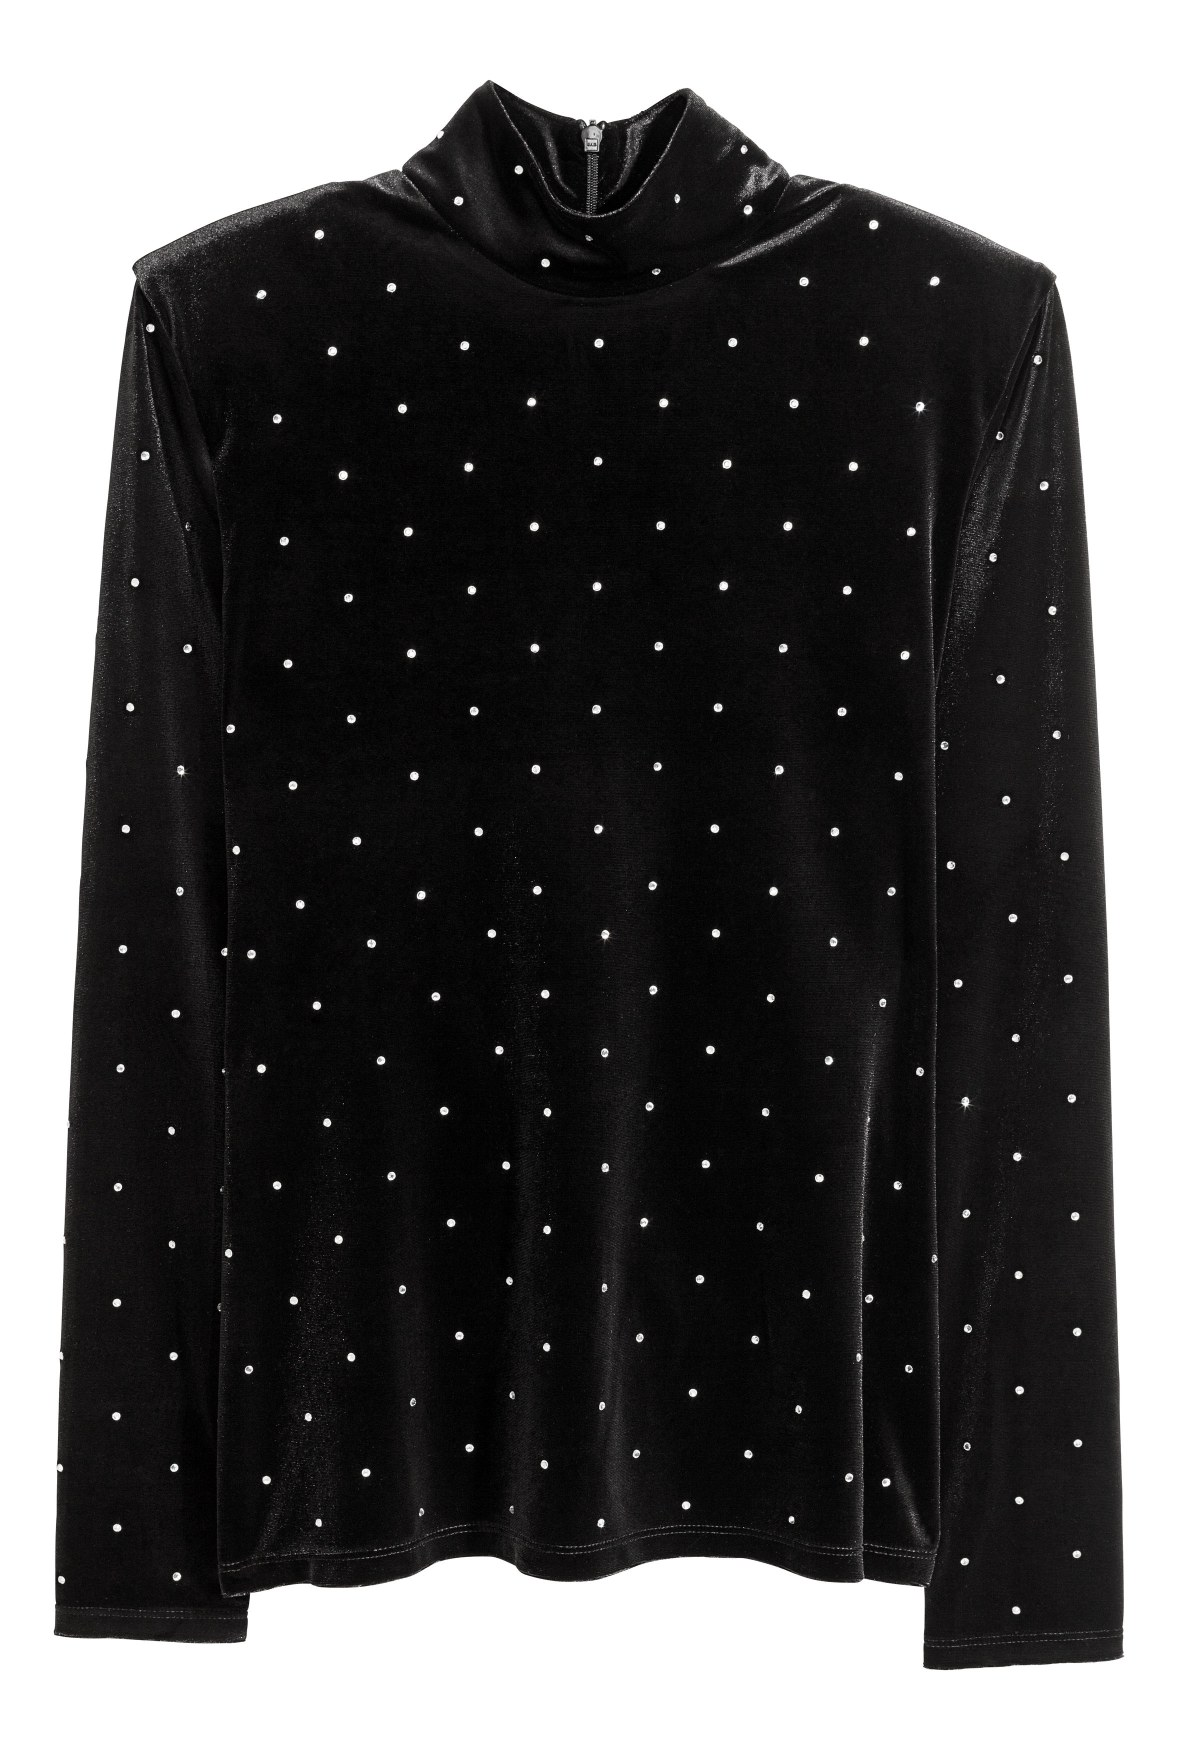

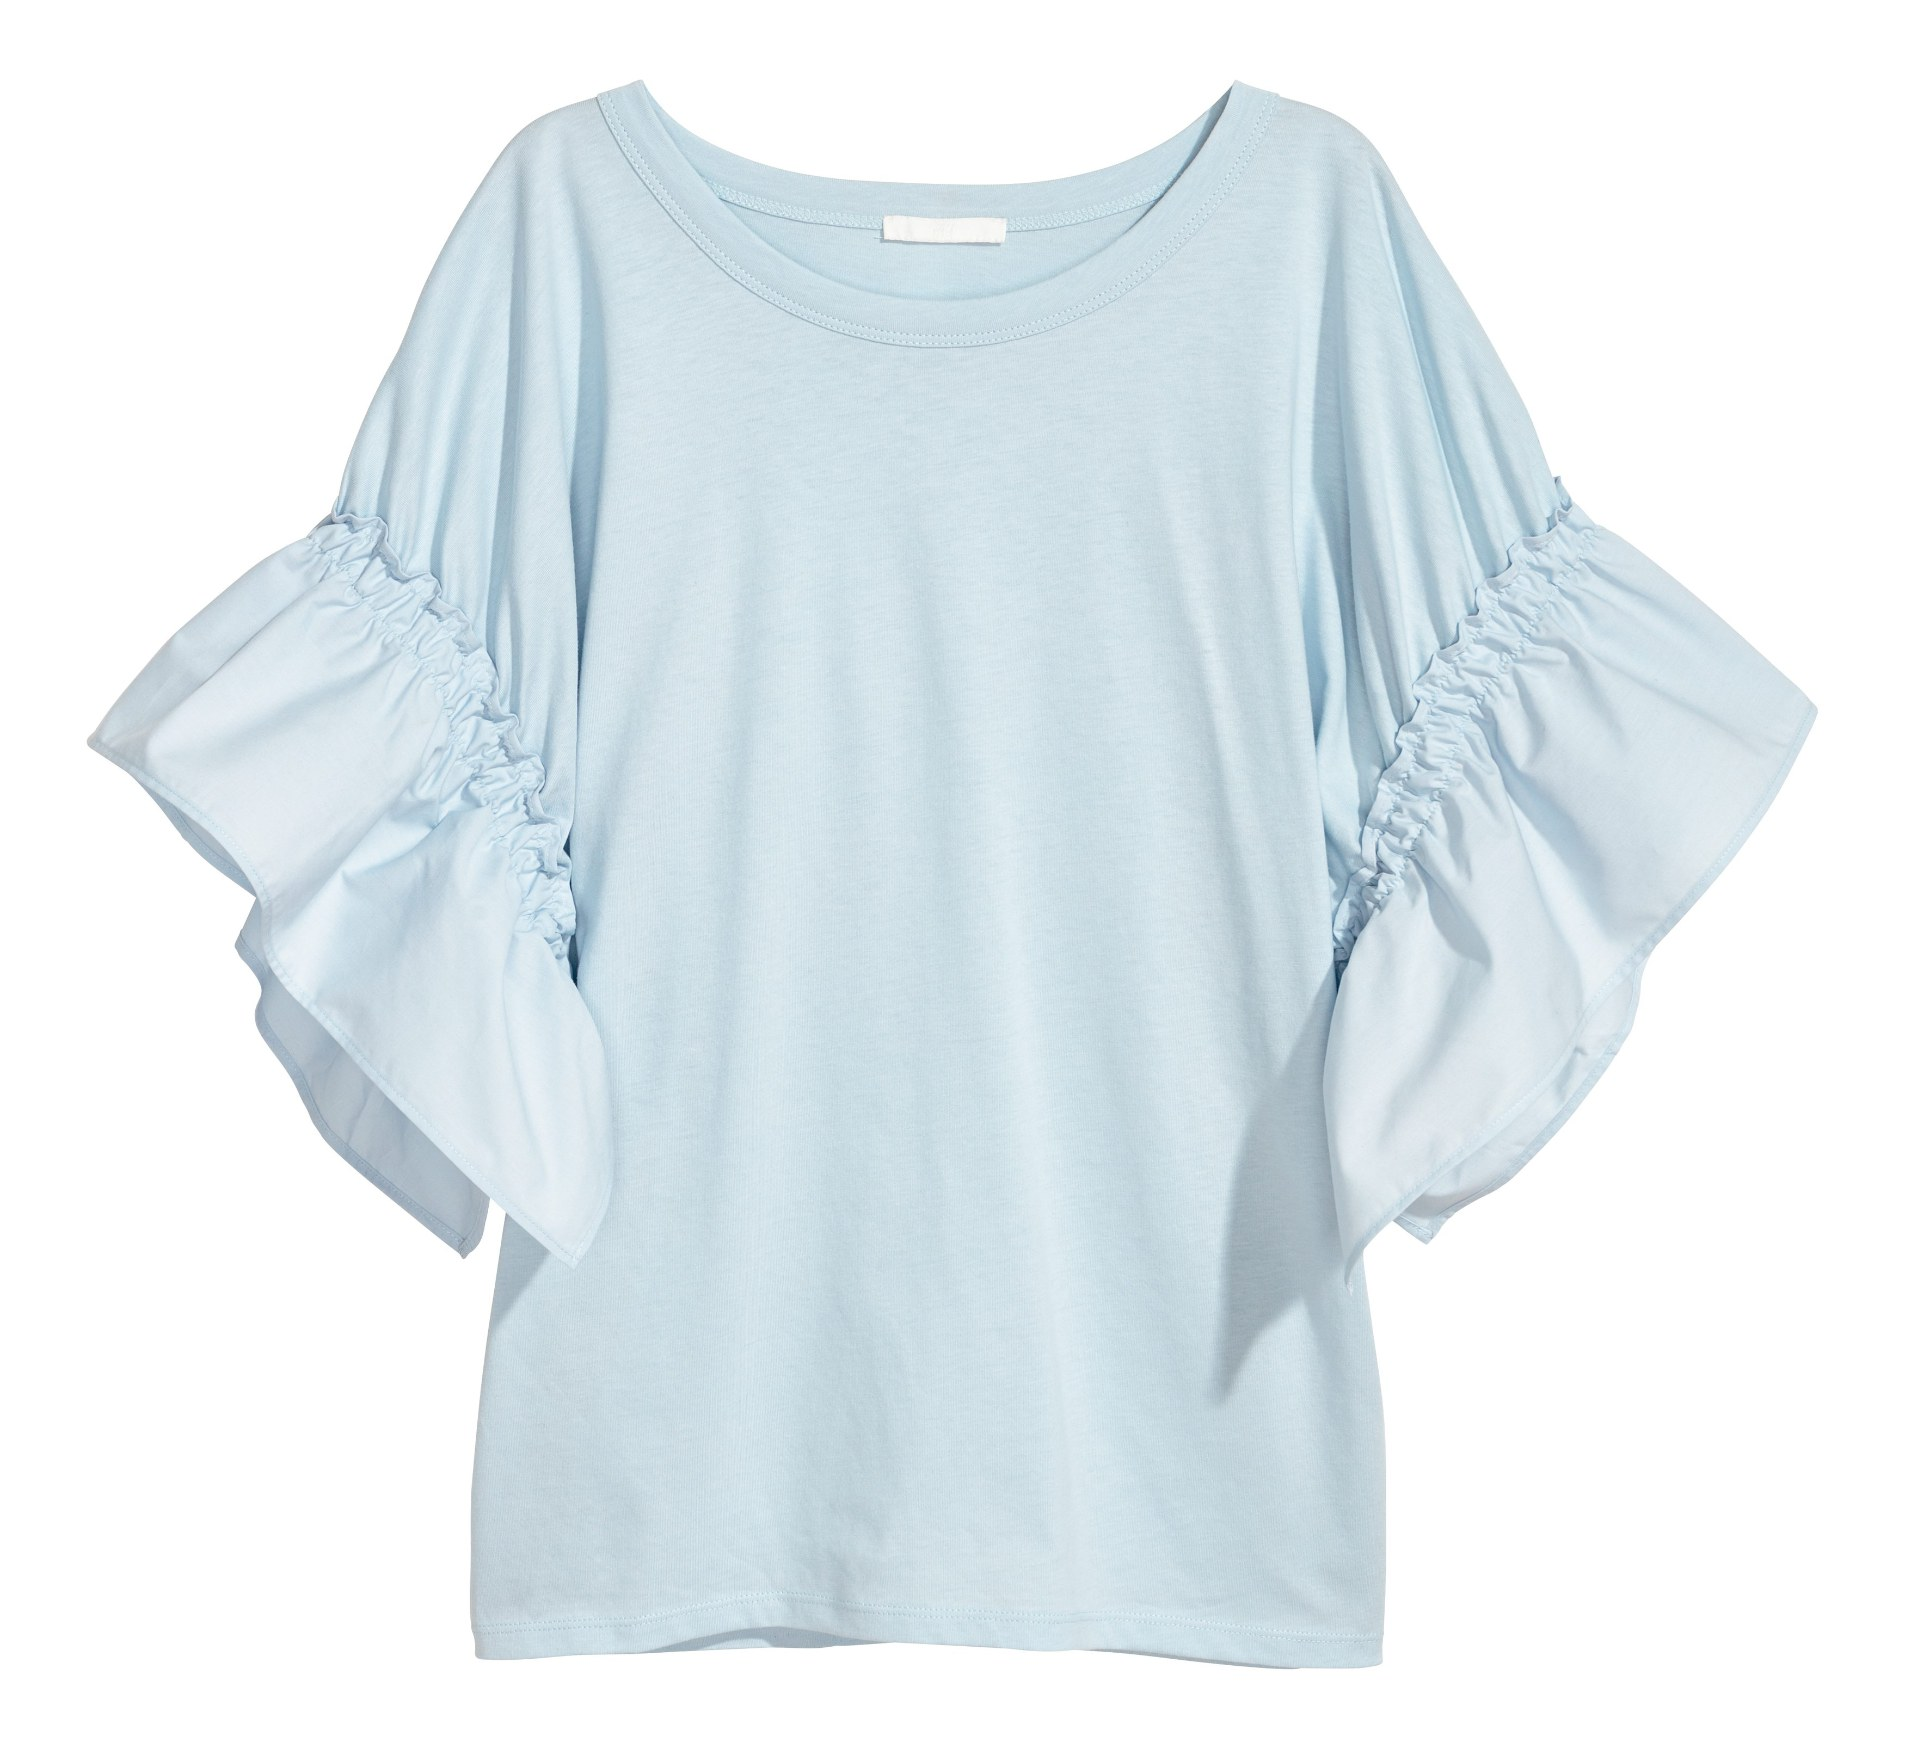

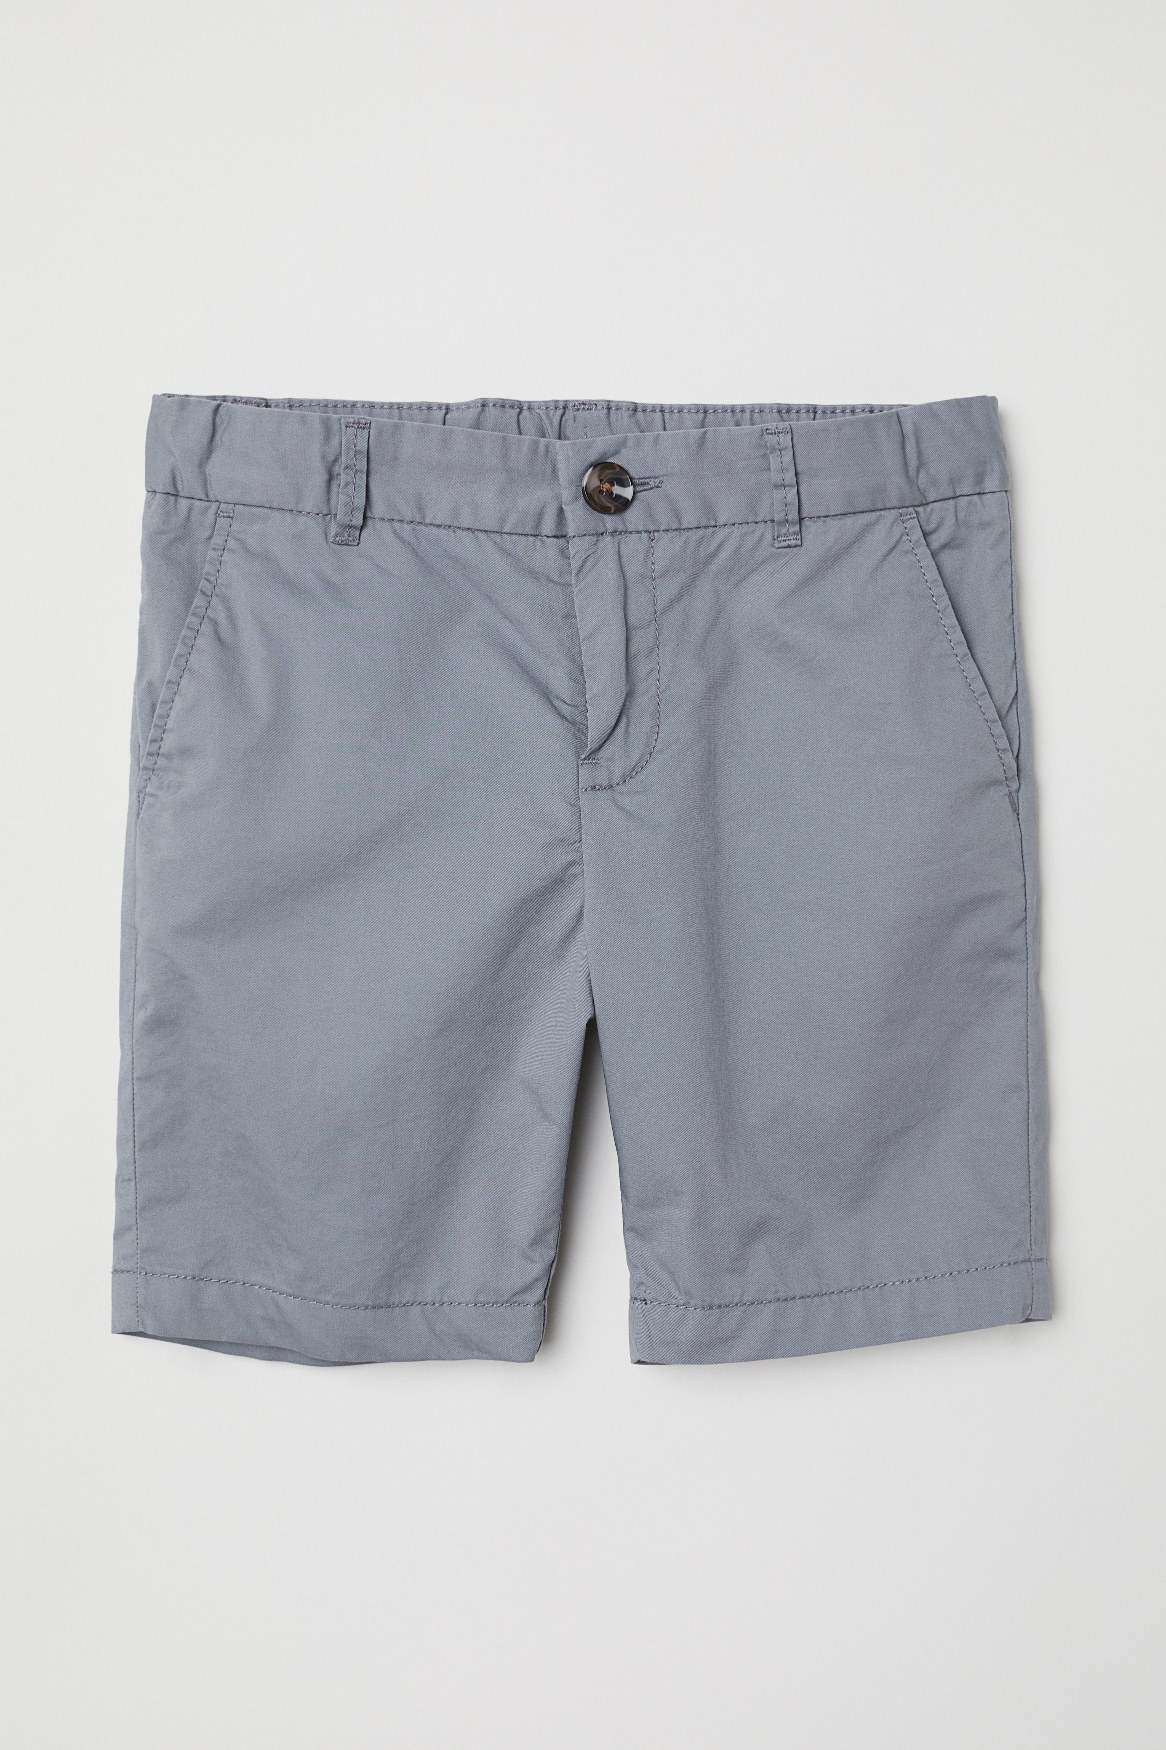

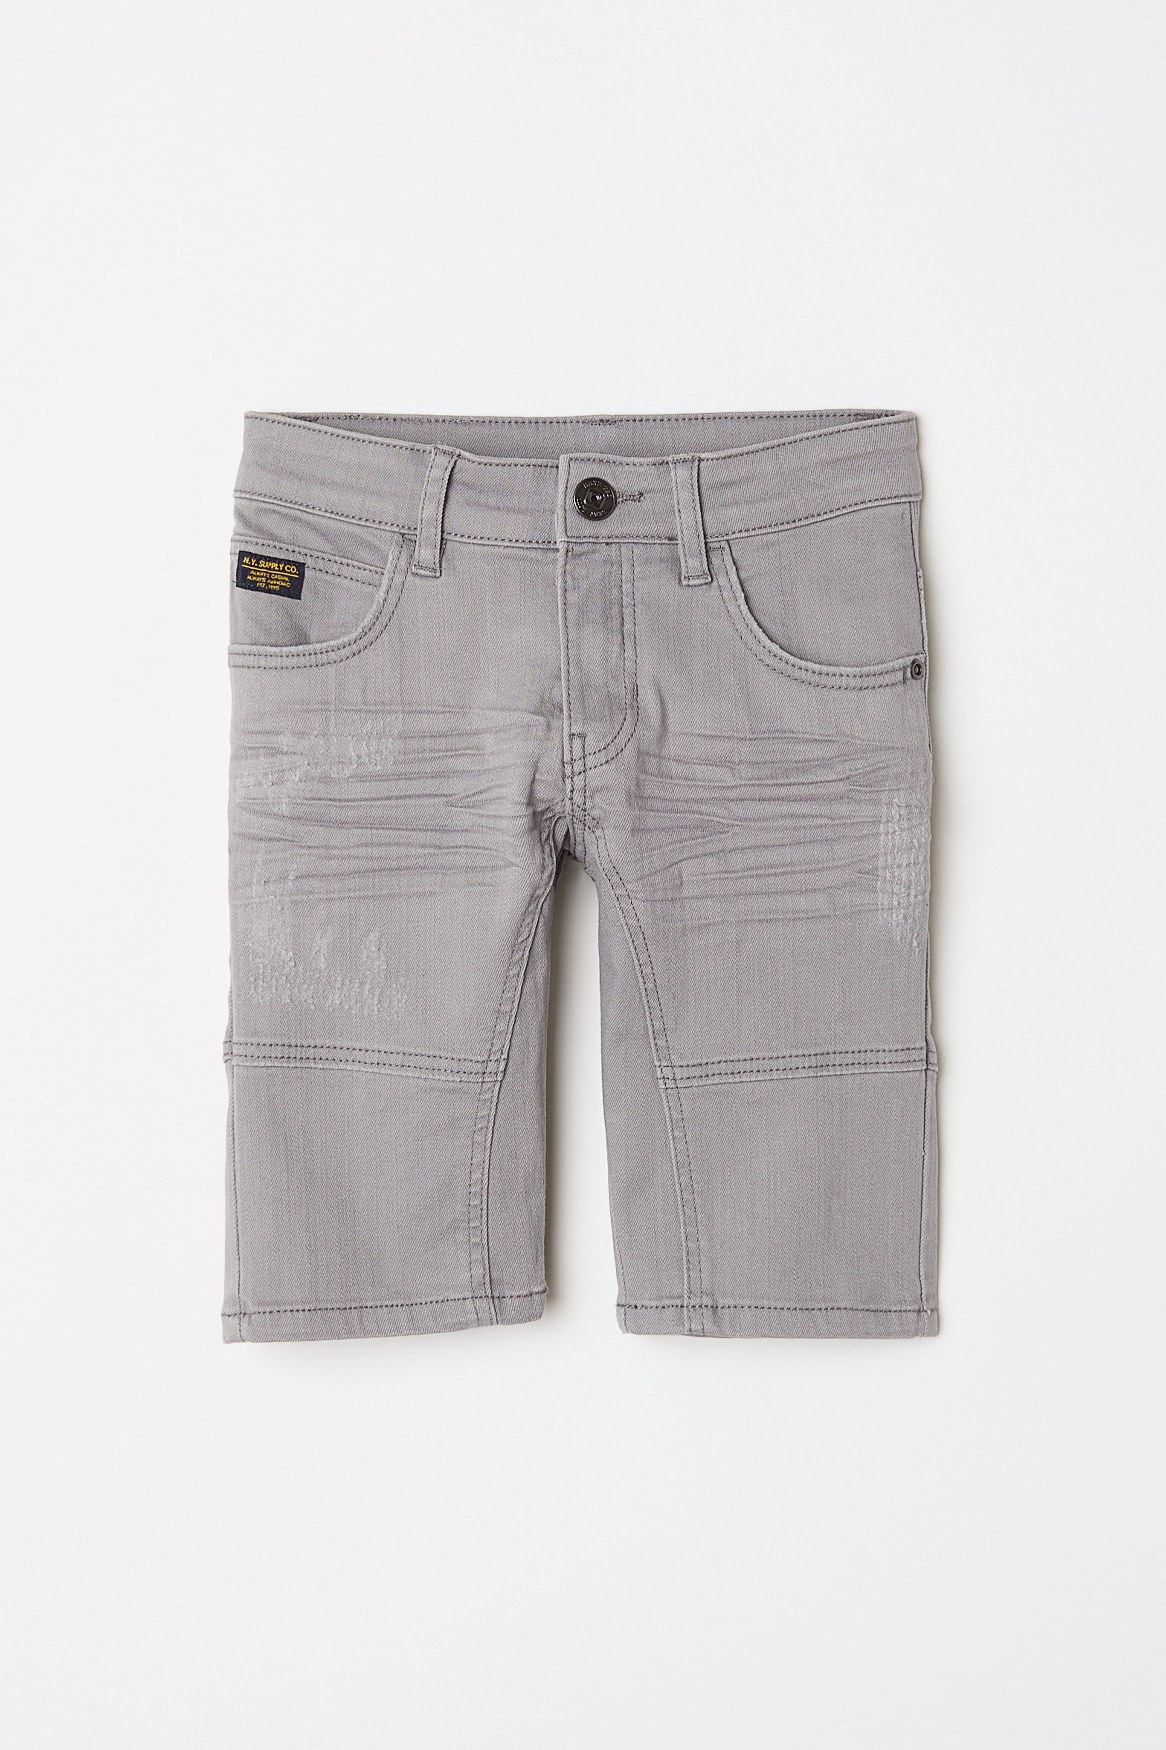

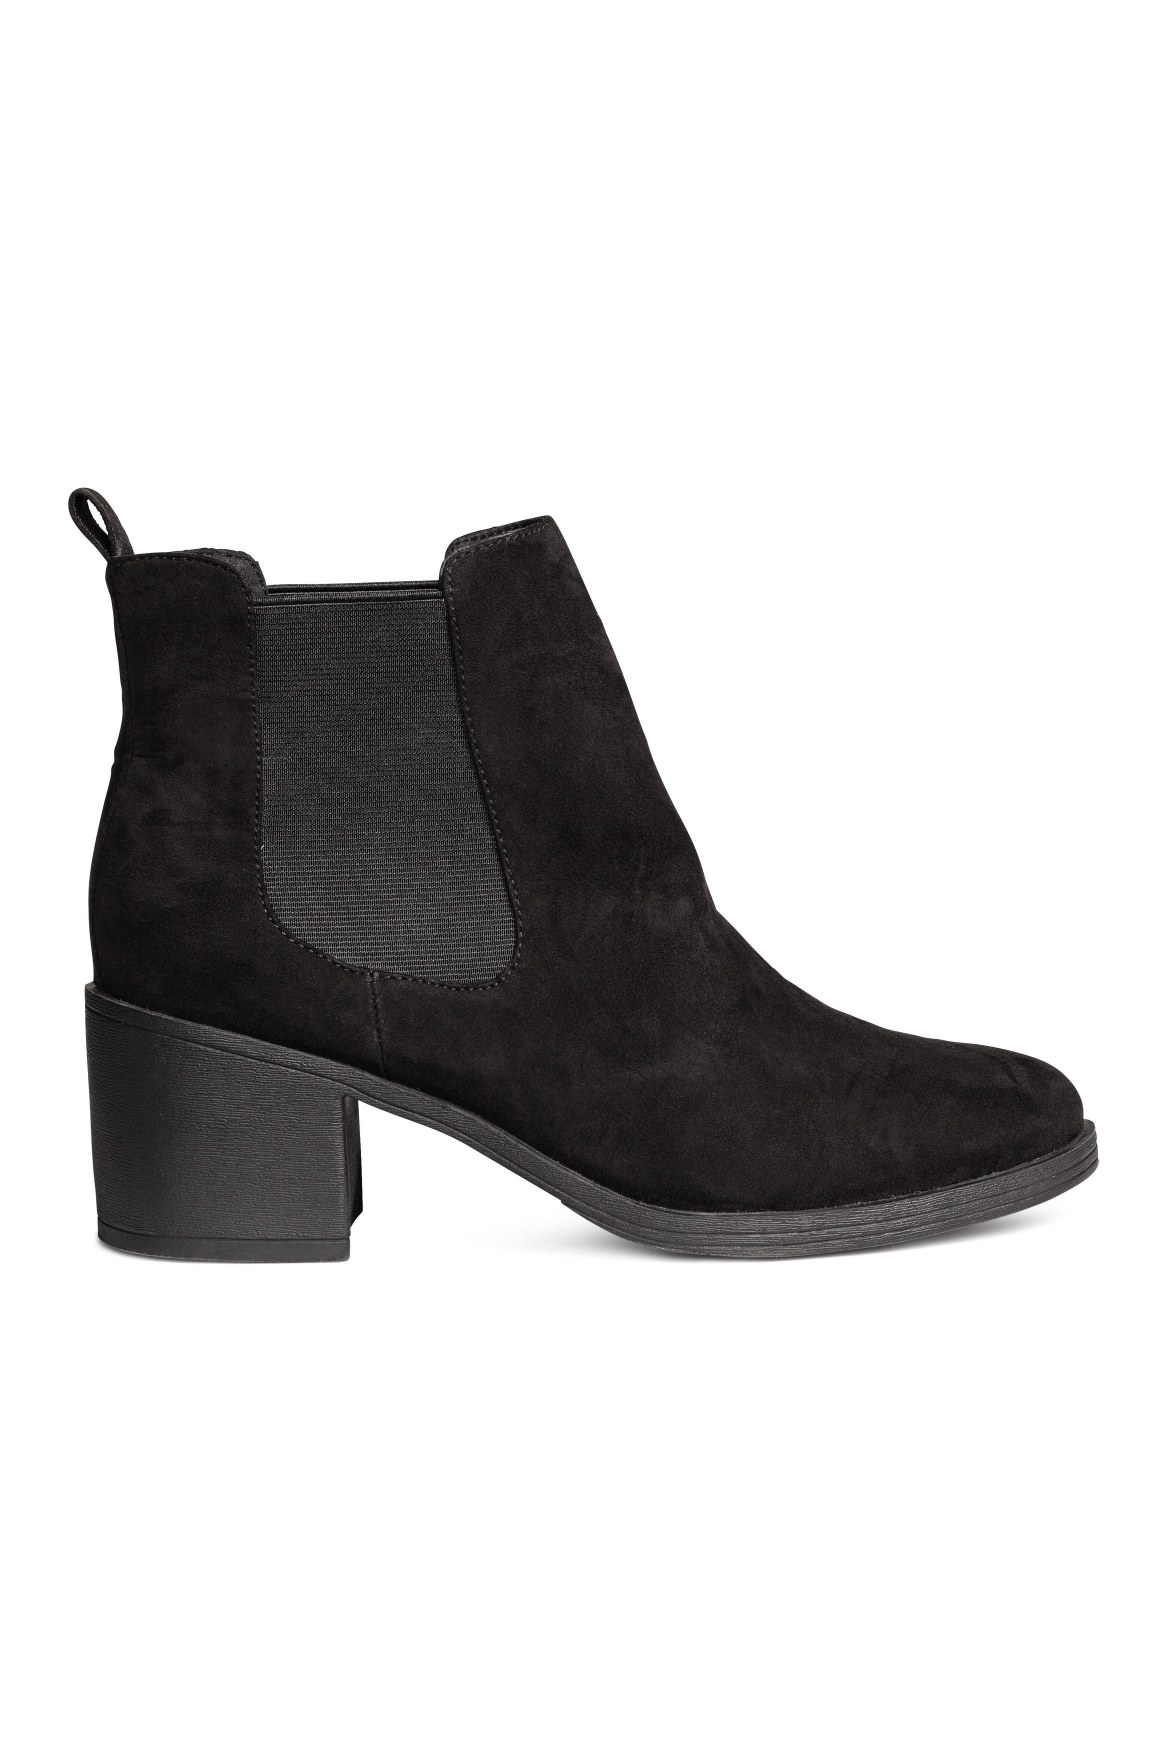

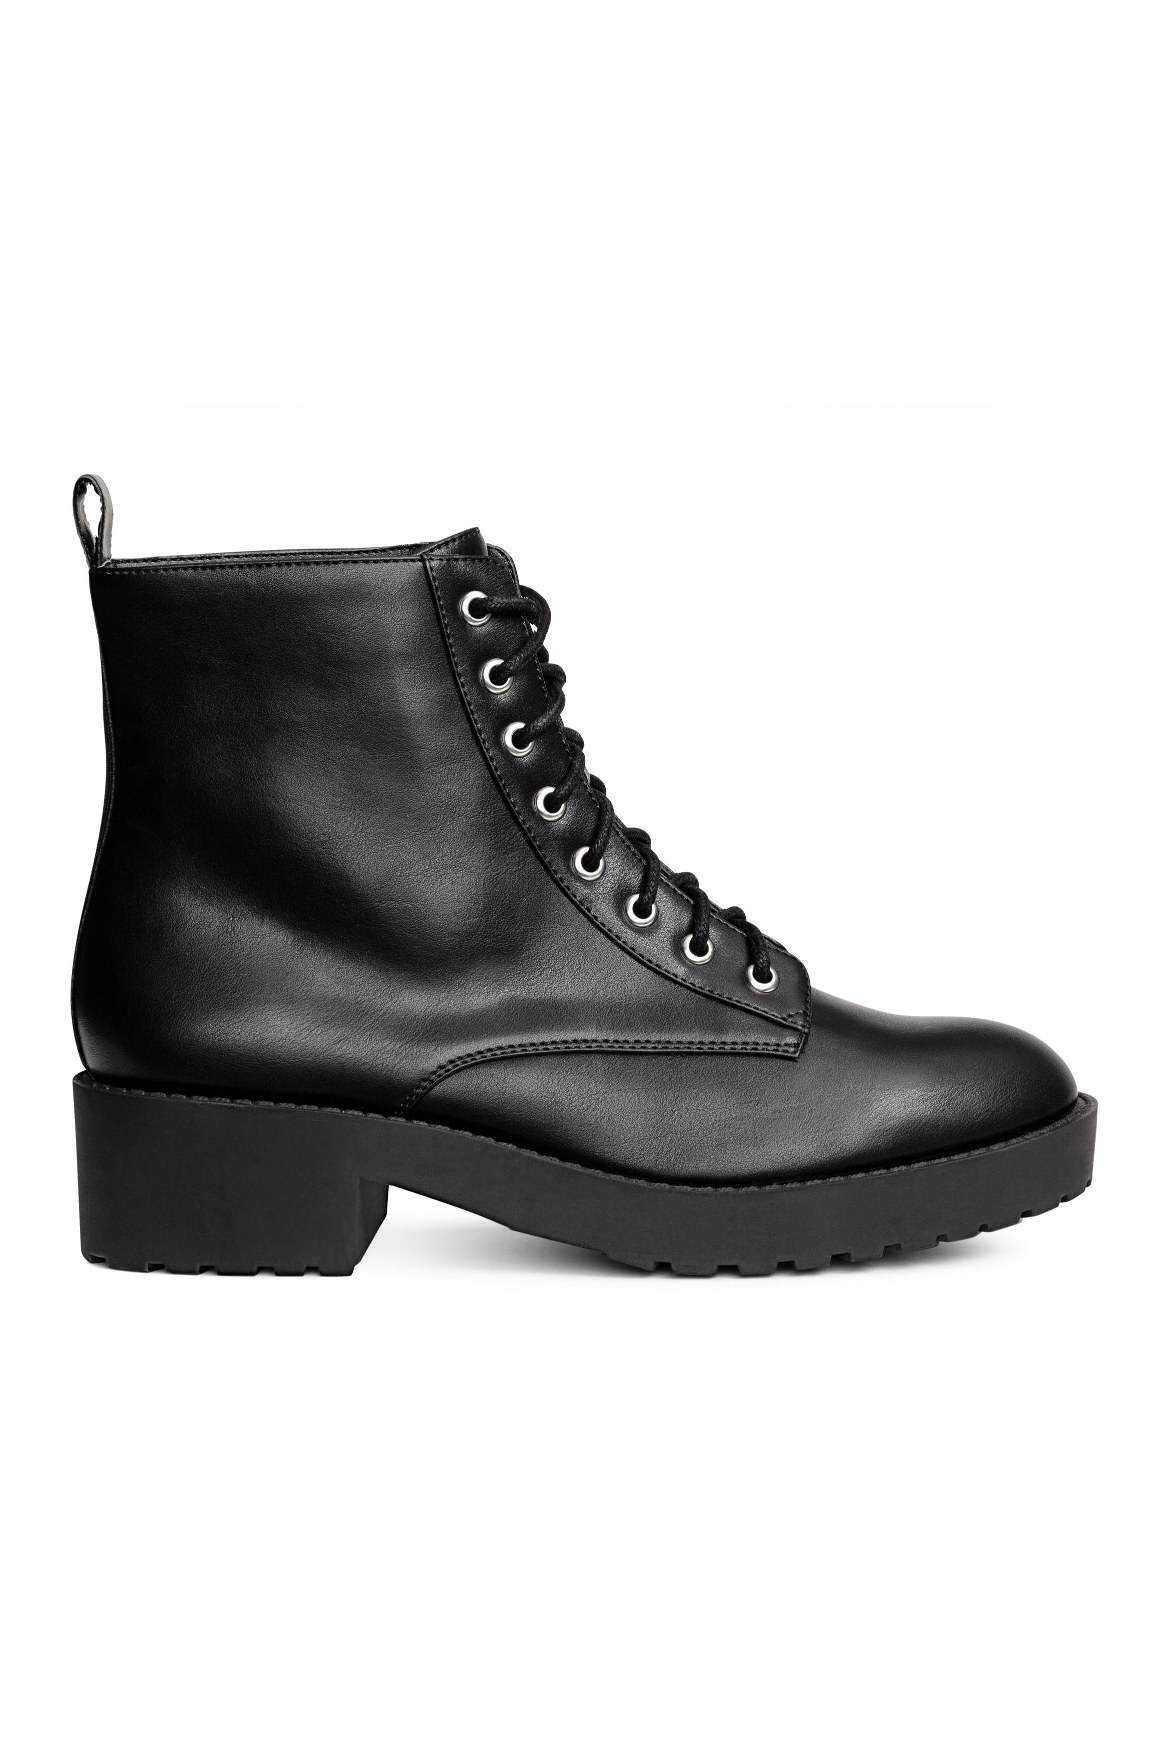

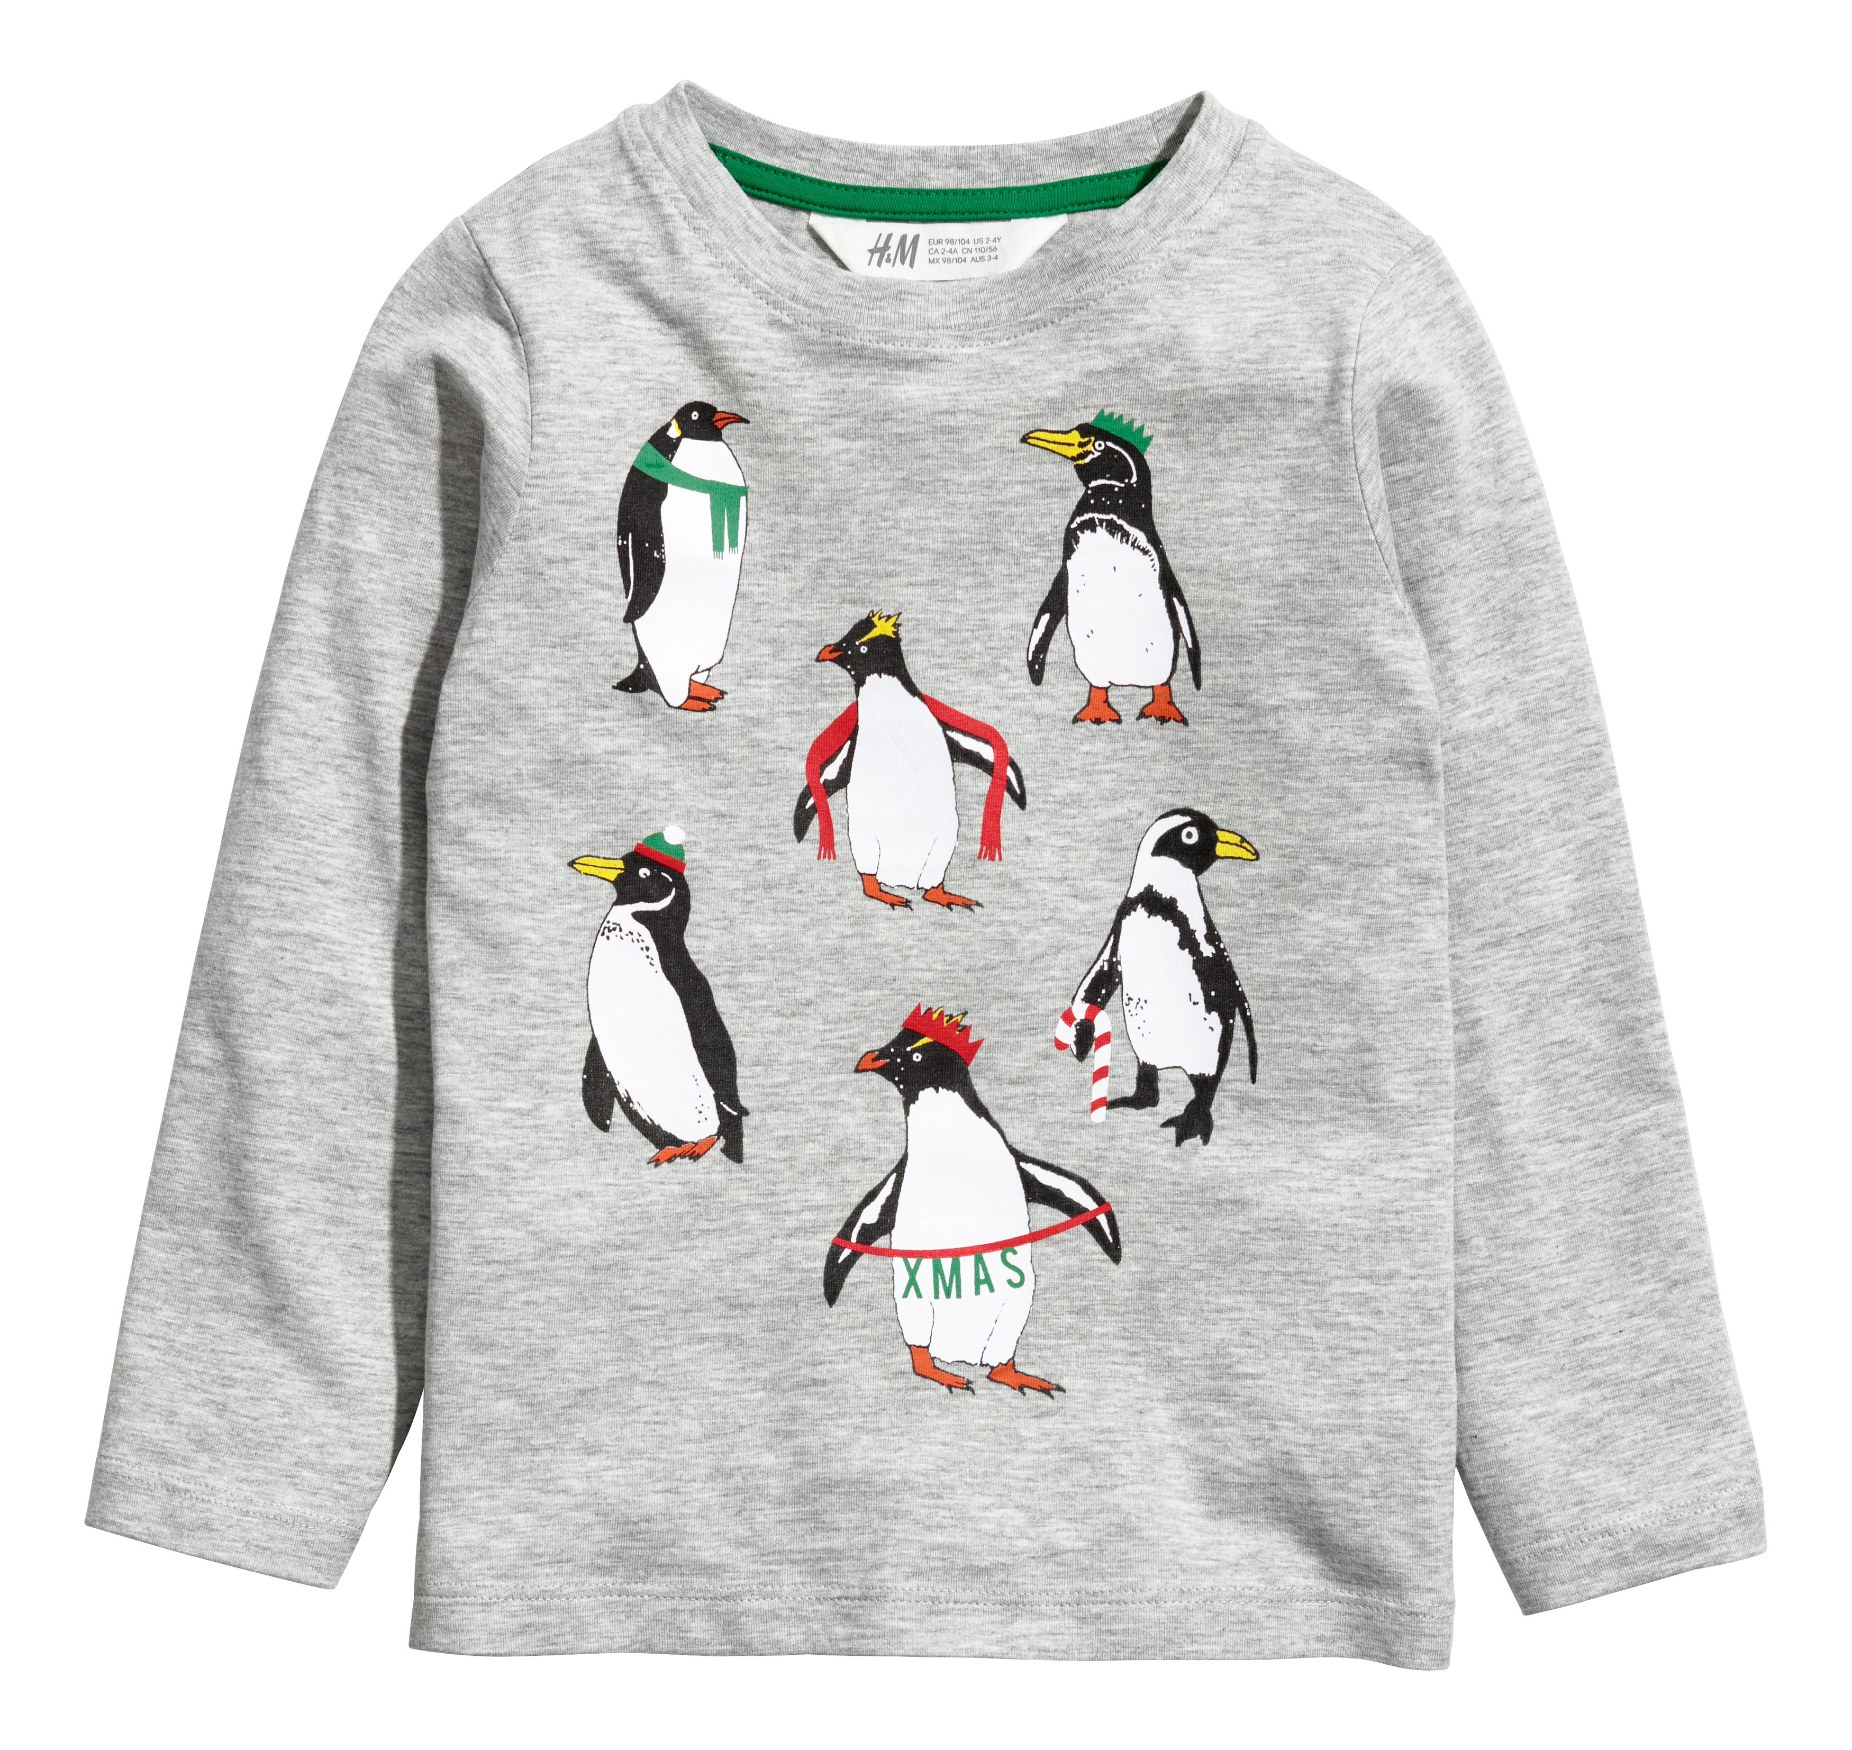

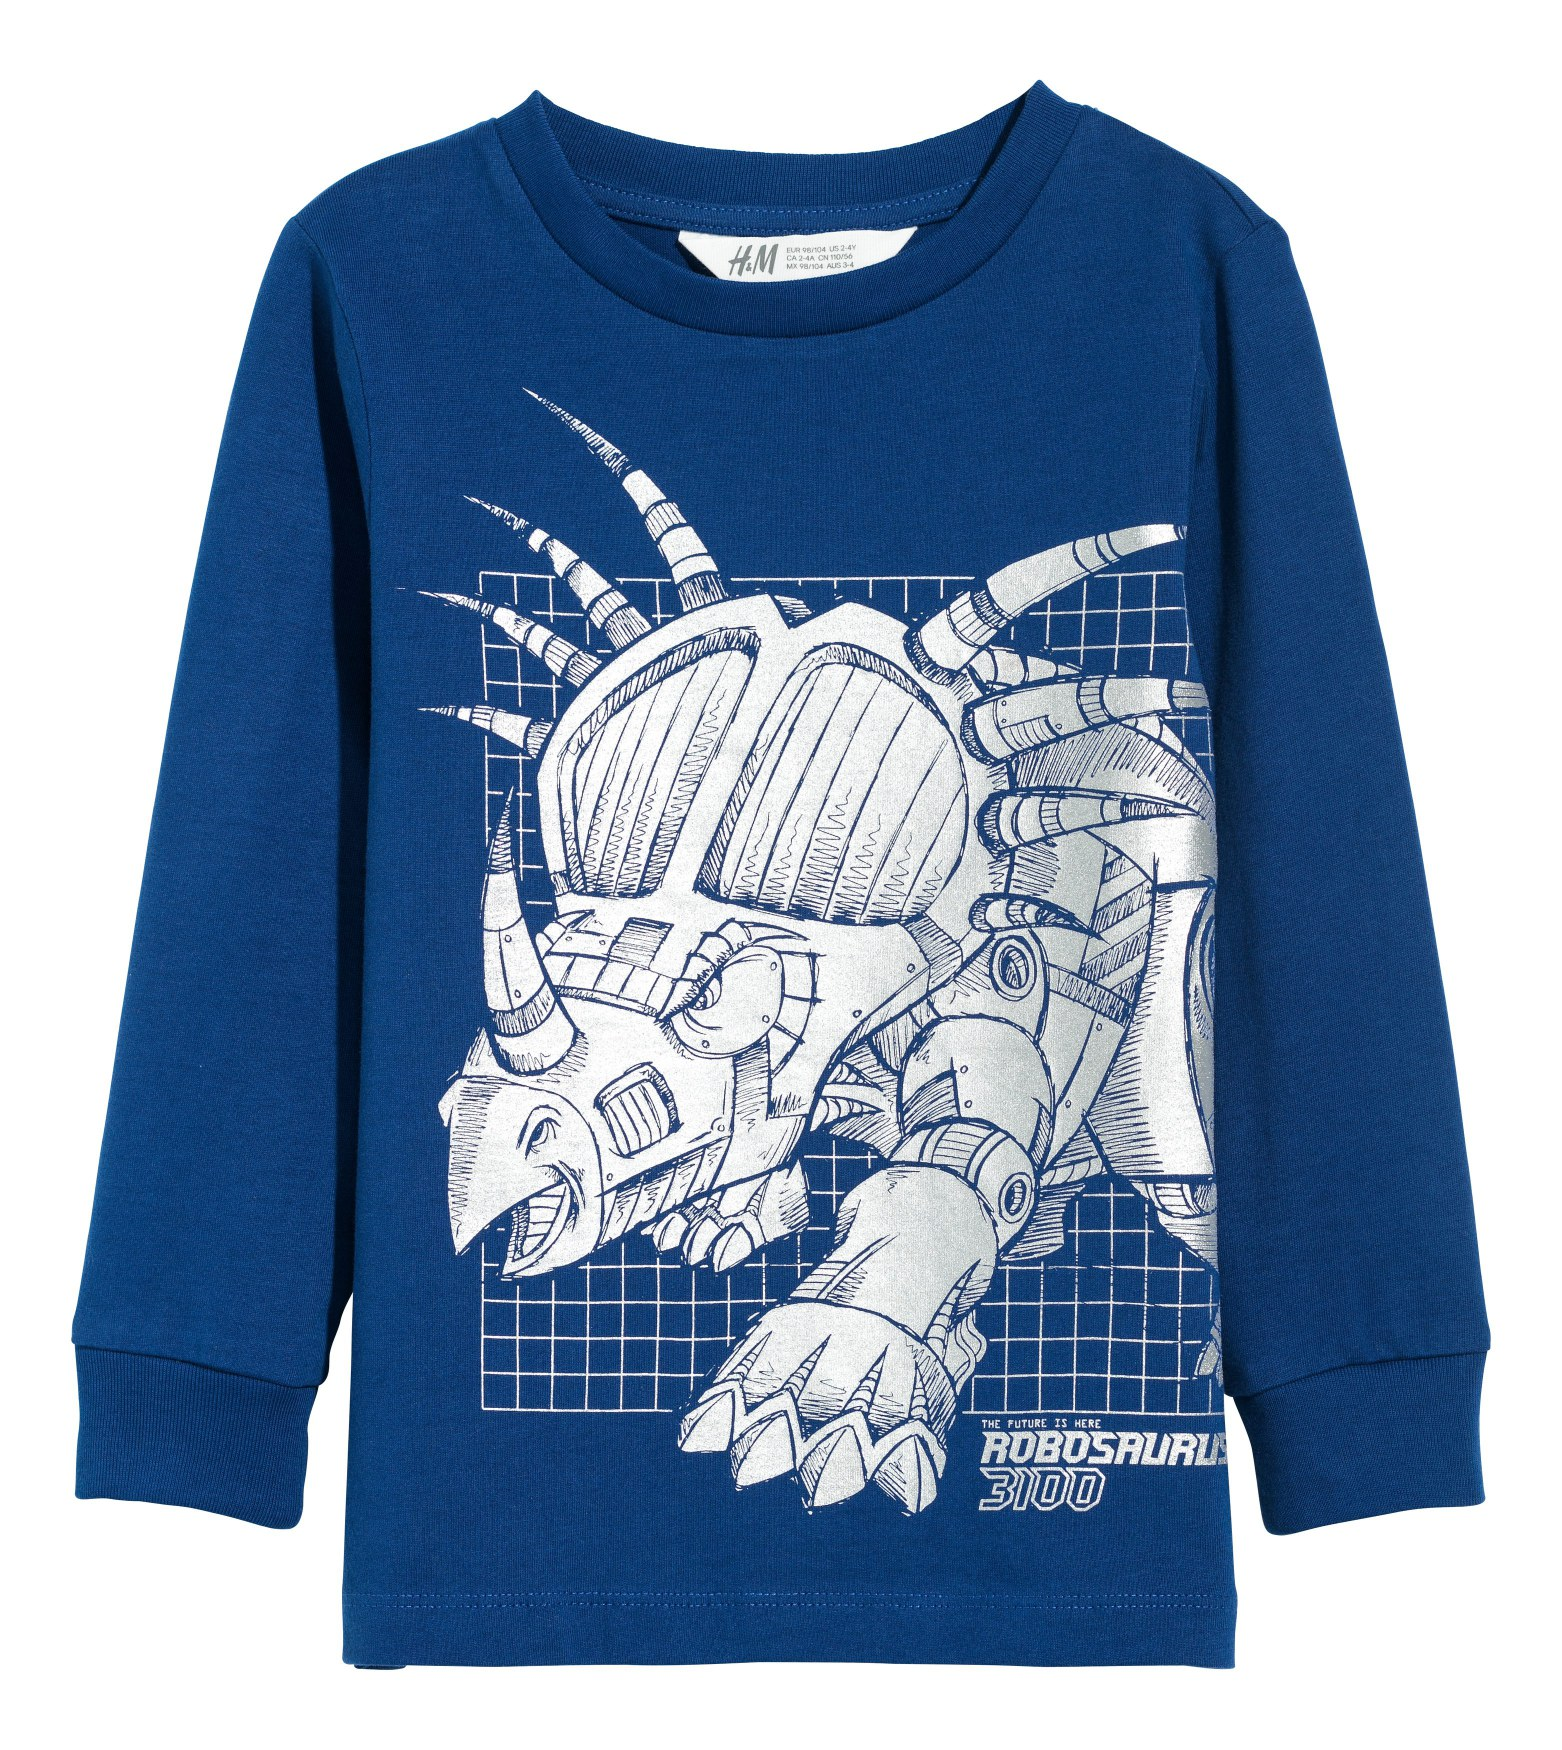

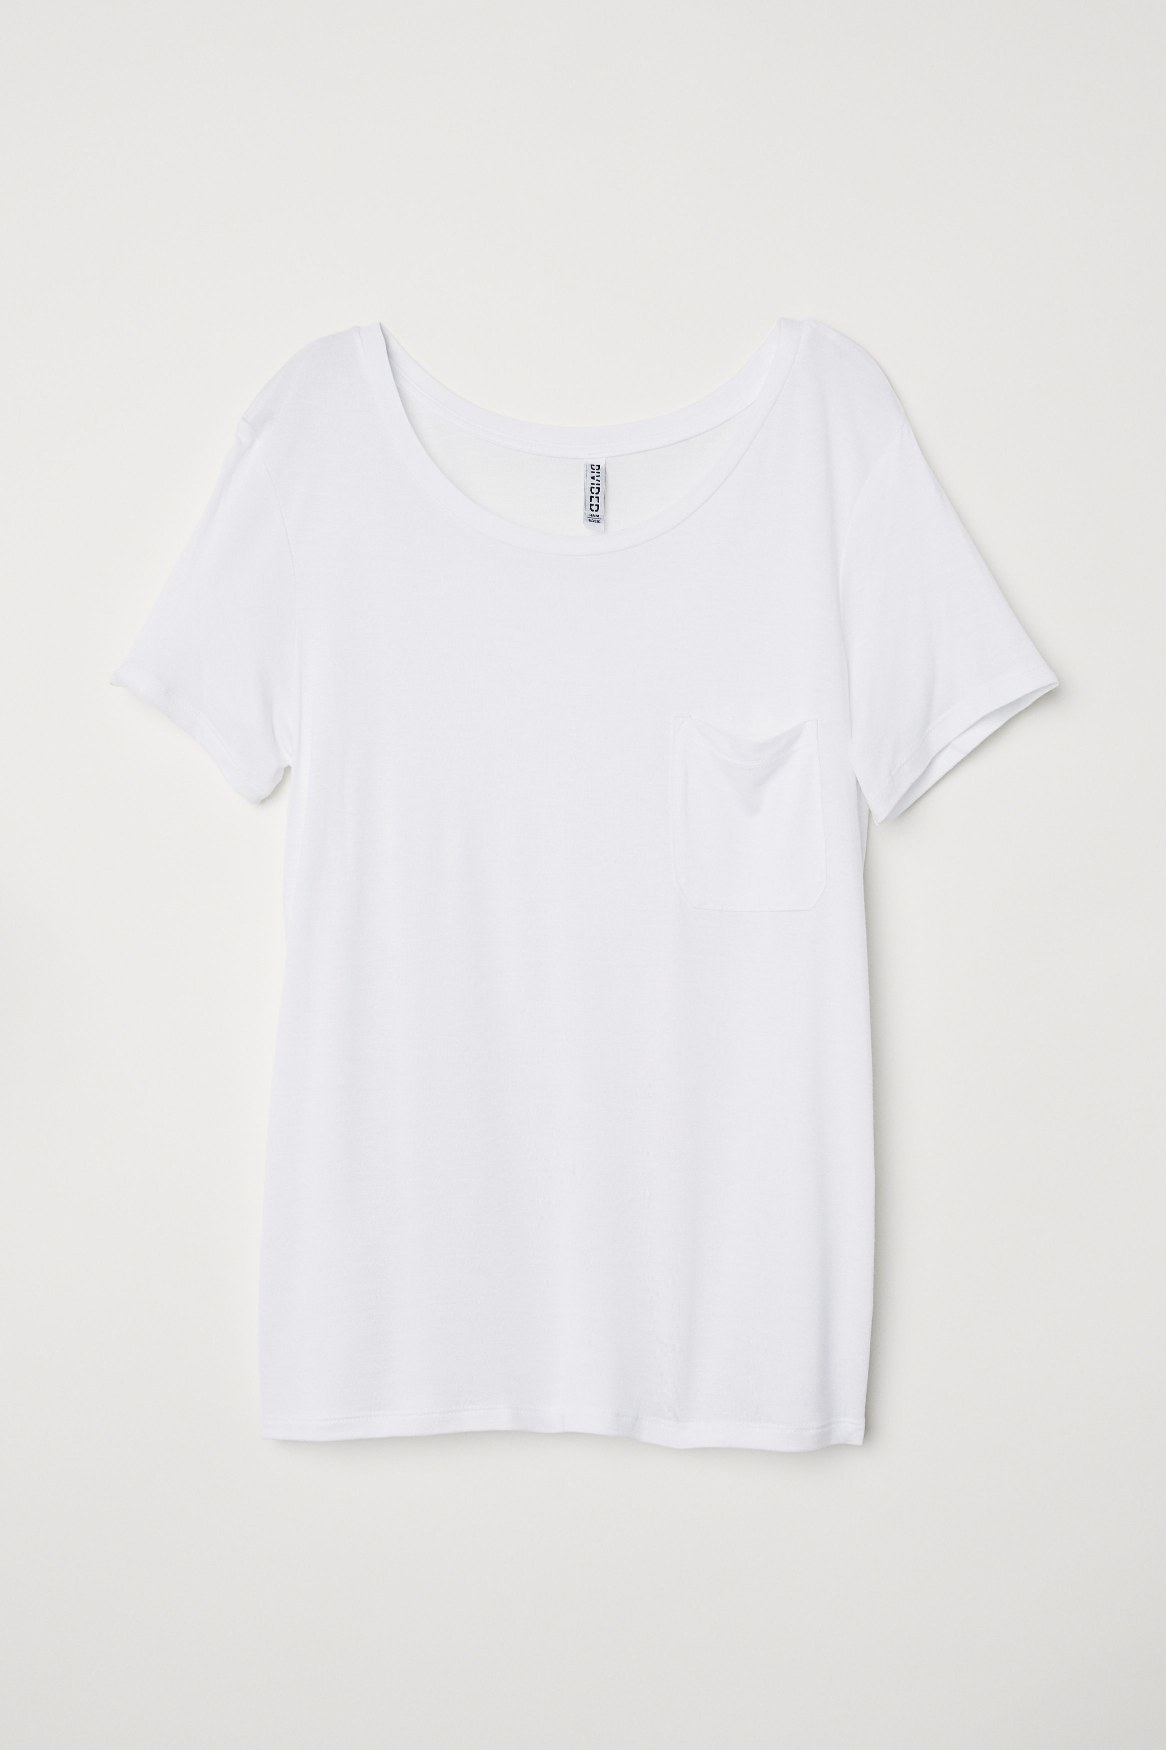

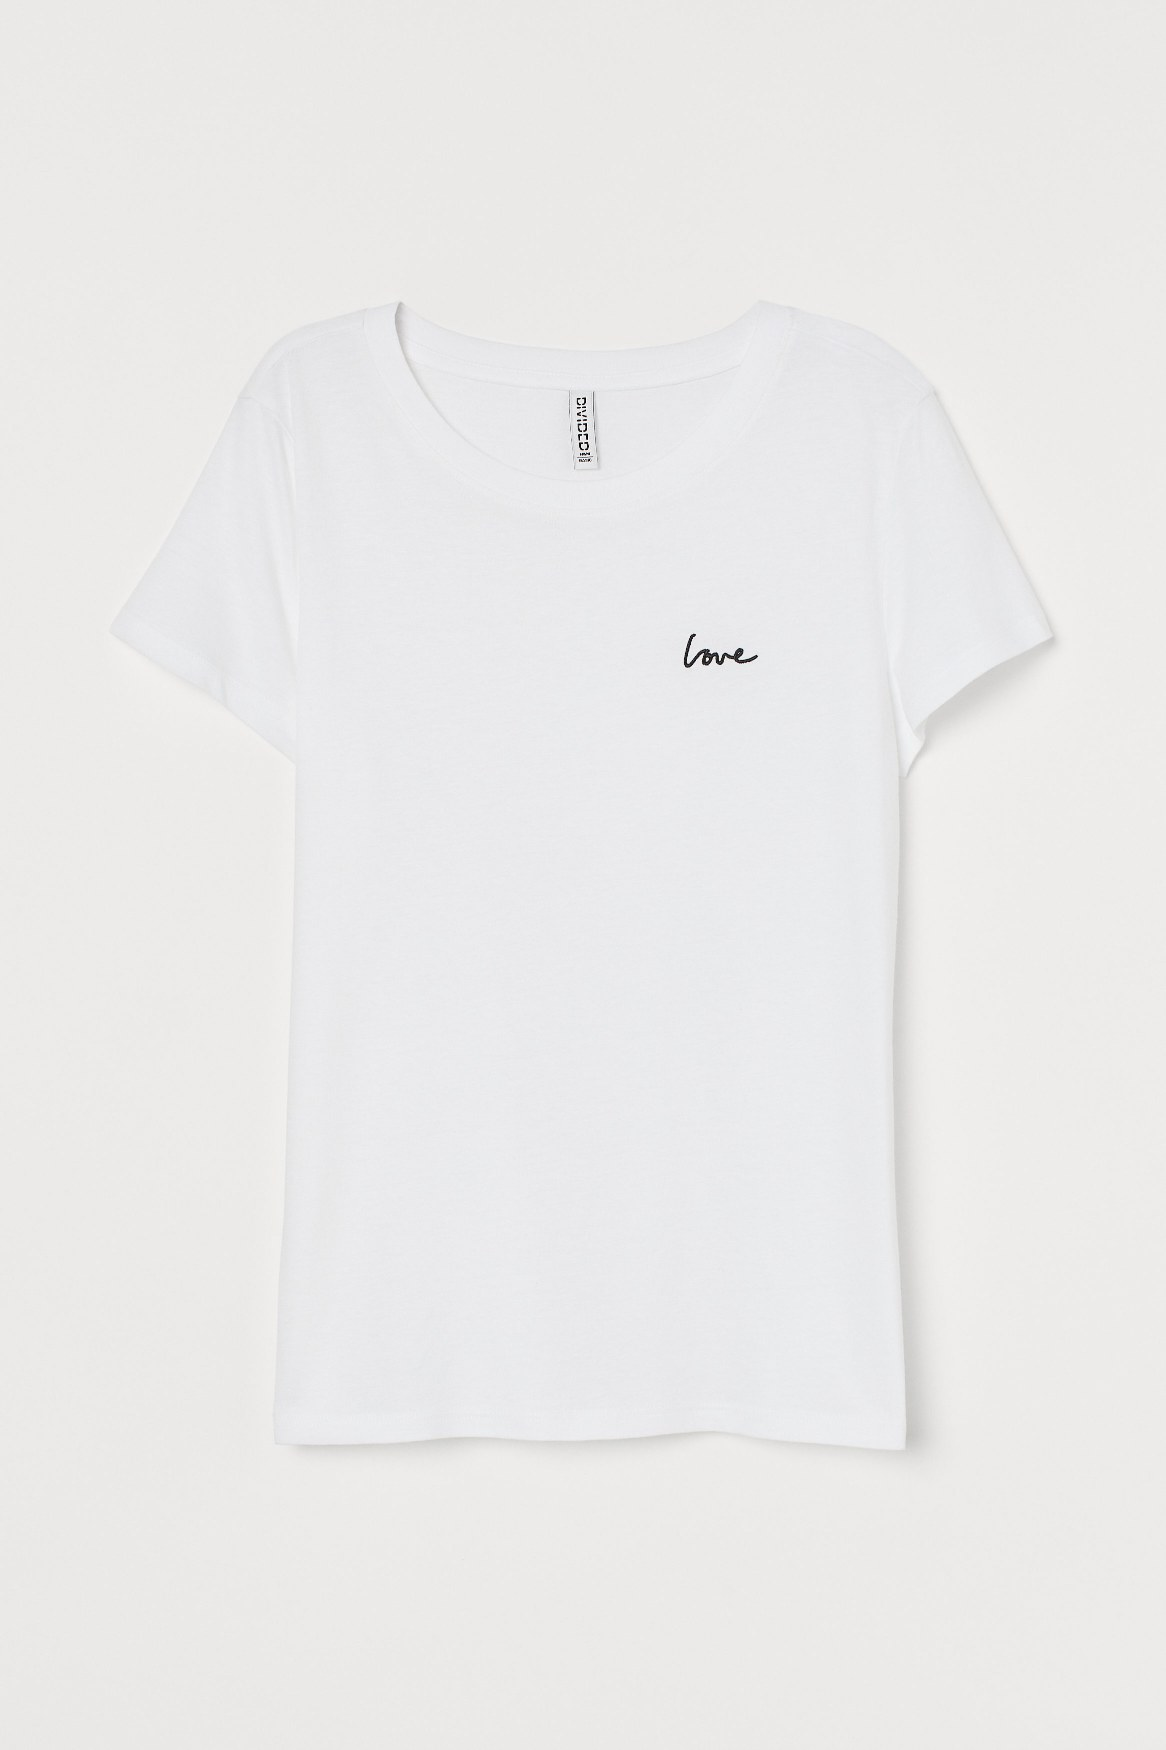

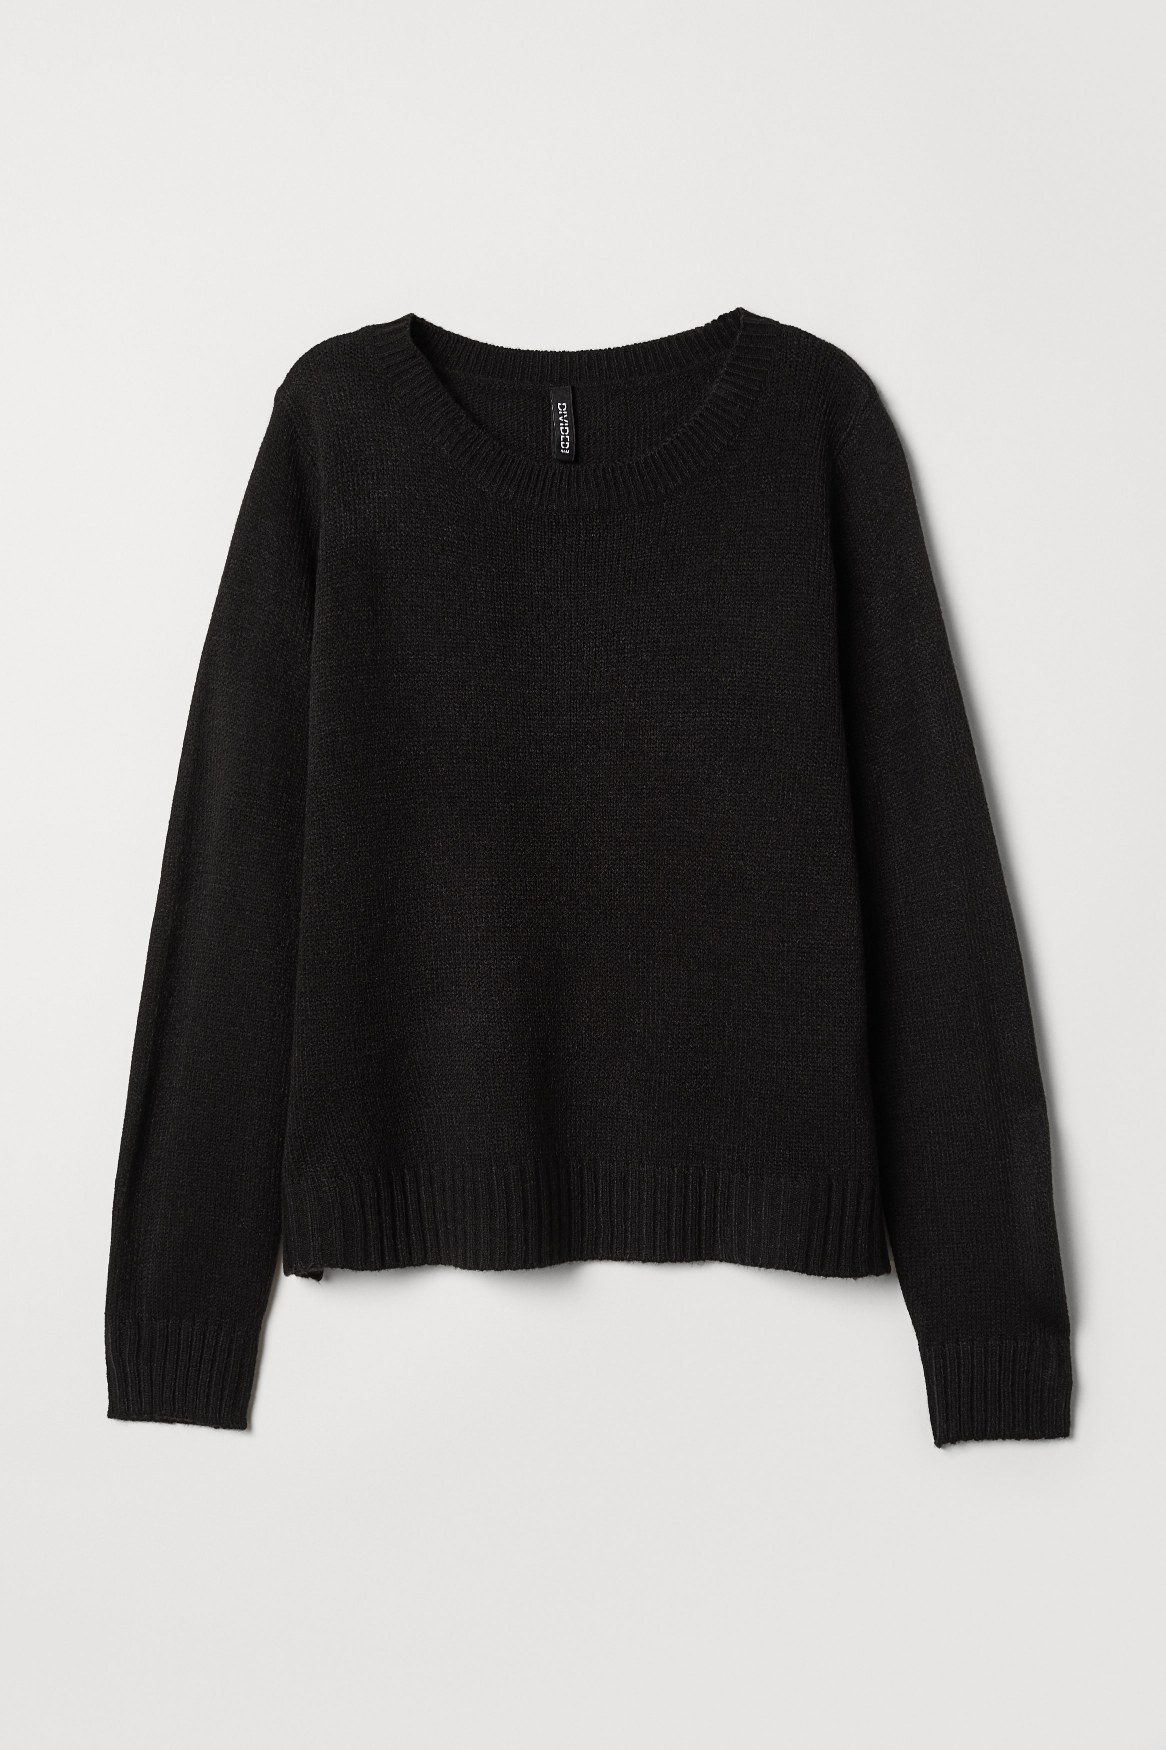

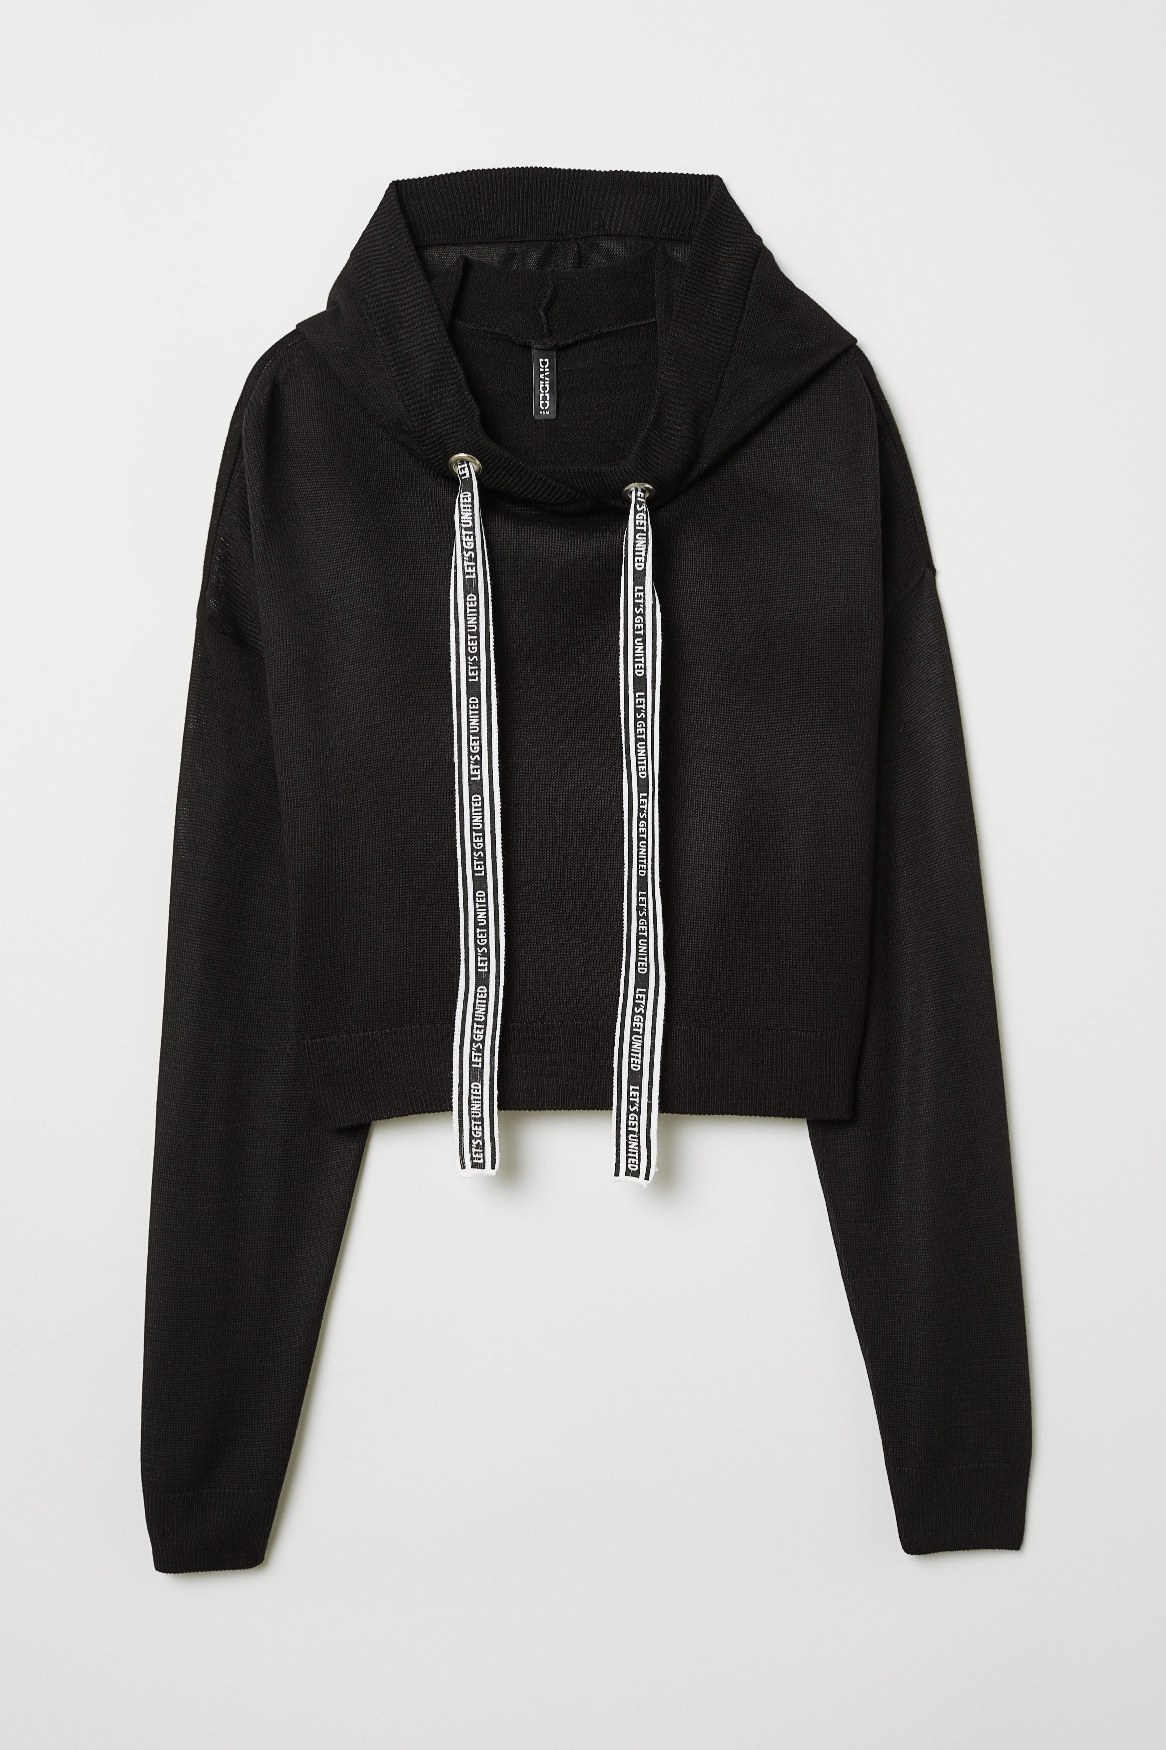

In [13]:
display_articles(toy, toy_recommendations_1st)

## Recommend all in train_x
Train_x has 10815 unique customers, recommend to all is time consuming. We will recommend for the intersection of cutomers with purchases in the last week (train_y) with purchases at train_x (otherwise a cold start)

In [ ]:
#539 in both out of 578 at train_y
toy_trainx_c_ids_with_y = toy_train_x_customer_ids[np.isin(toy_train_x_customer_ids,toy.train_y.customer_id.unique())]  

In [23]:
begin = datetime.now()
toy_recommendations_y_customers = toy_knn.recommend_all(toy_trainx_c_ids_with_y)   # 539, 1630 seconds=27mins
print('Seconds: ', (datetime.now() - begin).total_seconds())
toy_recommendations_y_customers.head()

Seconds:  1630.755839


customer_id  \
0  0864c58e052b243273d2ab33df294f8e03e9299f84a925...   
1  0cc82ebae4e0e50bb78179242d10f44e120e3bdb694b91...   
2  0e7adb227657cb54524f815440a73d5cebf3da3871dbdc...   
3  516843afa050238837b708073a7bdbbe80a0b04bb19d0c...   
4  6181c70b68214caf8ff44baa2d309d44ddc24c6e1f42da...   

                                          prediction  
0  0280256001 0341452001 0717664004 0534044001 04...  
1  0697054051 0768465001 0516903017 0749821004 05...  
2  0280256001 0341452001 0244267004 0479604003 05...  
3  0512631001 0521978001 0737040003 0835561004 04...  
4  0504154019 0519737006 0562245050 0562251008 02...

In [24]:
# Saving the file locally (Gina)
# toy_recommendations_y_customers.to_csv('../gina/toy_y_relevant_539.csv')

In [20]:
# Note: this implementations takes about the same that the original in the package
# def recommend_all_new(knn, customer_list, drop_duplicates=True):   # 284 seconds for 100 customers, #289 without df
#     all_customers = []
#     for c in customer_list:
#         recommendations = knn.recommend(c, drop_duplicates=drop_duplicates)
#         all_customers.append([c, " ".join(recommendations)])
#     df = pd.DataFrame(all_customers, columns=["customer_id","prediction"])
#     return df

In [19]:
# begin = datetime.now()
# recommend_all_new(toy_knn, toy_train_x_customer_ids[:100])
# print('Seconds: ', (datetime.now() - begin).total_seconds())
# toy_recommendations.head()

Seconds:  289.169101


## Scores for toy dataset

In [25]:
rel_y = datasets.target_to_relevant(toy.train_y)
t = scoring.relevant(toy_recommendations_y_customers, rel_y)
print('t has {} records \n'.format(t.shape[0]))

# print("precision_at_k:")
# for i in range(len(t[0])):
#     print(scoring.precision_at_k(t[0][: i + 1]))

print("ap_at_k:")
print(t.apply(scoring.ap_at_k),'\n')

print("map_at_k:", scoring.map_at_k(t))

t has 539 records 

ap_at_k:
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
534    0.0
535    0.0
536    0.0
537    0.0
538    0.0
Length: 539, dtype: float64 

map_at_k: 0.0
